# Rigetti's noise modeling exploration

In this section we will explore the Rigetti's Forest SDK feature to model on the Quantum Virtual Machine, the noise that would occur on the real quantum computer.<br>
There are multiple types of noise, but for now we will consider only the noise arising from decoherence, which has many souces: gravity causes decoherence if one states weights more than the other; there may be stray long range fields, typically associated with charge; there can be leakage into larger Hilbert spaces; a two state atom may have higher energy levels that the state can move to.<br>
The are two measures of decoherence, $T_{1}$ and $T_{2}$.<br>

$T_{1}$ is called "longitudinal coherence time" or "amplitude damping" and it measures the loss of energy from the system. One can do an experiment to determine it. First initialize the qubit to the ground state $|0\rangle$. Then apply $X$, wait for the time <i>t</i> and measure the probability of being in the $|1\rangle$ state. We expect an exponential decay from 1 to 0 following $e^{\frac{-t}{T_{1}}}$

$T_{2}$ is called "transverse coherence time" or "phase damping" and it can be measured, too. First initialize the qubit to the ground state $|0\rangle$, apply the <i>H</i> gate, wait for time <i>t</i>, apply <i>H</i> again and finally measure the probability of being in the state $|0\rangle$. It should goes to $\frac{1}{2}$ because after some time, an interference with the system will probably have brought the state to either $|0\rangle$ or $|1\rangle$. Hence, by applying the second <i>H</i> we are bringing the qubit in superposition again, leading to a measurement probability of $\frac{1}{2}$.

In [37]:
from pyquil import Program, get_qc, list_quantum_computers
from pyquil.gates import *
from pyquil.noise import add_decoherence_noise
from pyquil.quilbase import Pragma
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from numpy import pi

Let's define the functions to obtain the frequencies of the result over the multiple executions of an algorithm and the function to plot them.

In [3]:
def get_frequencies(result, n_qubits):
    result_int = result.dot(2**np.arange(n_qubits)[::-1])
    int2binary = np.vectorize(np.binary_repr)
    result_string = int2binary(result_int, n_qubits)

    counts = Counter(result_string)
    bit_strings = int2binary(np.arange(0, 2**n_qubits), n_qubits)
    counts = [counts[bit_string] for bit_string in bit_strings]
    frequencies = [value/len(result_int) for value in counts]
    return frequencies, bit_strings

def plot_result(result, n_qubits):
    frequencies, bit_strings = get_frequencies(result, n_qubits)

    plt.bar(bit_strings, frequencies)
    axes = plt.gca()
    axes.set_ylim([0.0,1.0])
    plt.show()

We can then instantiate a new Quantum Virtual Machine. Note that differently from the previous times, we specify the parameter noisy to be False. Actually this is not necessary because the default value is already False.
    Let's try to see if by running a circuit composed only by the <i>X</i> gate starting from the ground state $|0\rangle$ we always measure the state $|1\rangle$.

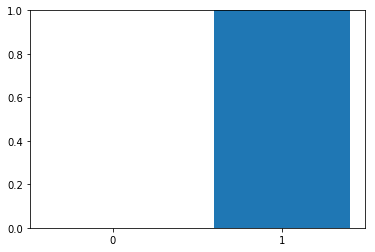

In [4]:
qvm = get_qc('9q-square-qvm', noisy=False)
n_qubits = 1
qubits = list(range(n_qubits))
p = Program()
p += X(0)
p = p.measure_all()
p.wrap_in_numshots_loop(100)

#Compile and run
prog = qvm.compile(p)
result = qvm.run(prog)
plot_result(result, n_qubits)

Since we are modeling an "ideal" quantum computer through the QVM, our results are not affected by noise, so we obtain $|1\rangle$ in the 100% of the cases.

We can now execute the same program, but using a QVM that emulates the a generic noise by setting the noisy parameter to True. Aspen-1-16Q-A

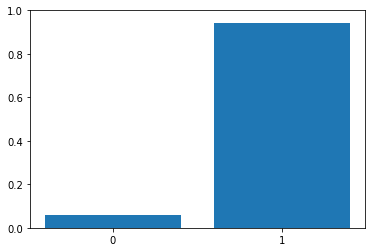

In [5]:
qvm = get_qc('9q-square-qvm', noisy=True)
n_qubits = 1
qubits = list(range(n_qubits))
p = Program()
p += X(0)
p = p.measure_all()
p.wrap_in_numshots_loop(100)

#Compile and run
prog = qvm.compile(p)
result = qvm.run(prog)
plot_result(result, n_qubits)

The noise modeled for a generic QVM is standard. It is also possible to emulate a specific Rigetti Quantum Computer, that can be viewed by executing <i>list_quantum_computers()</i>. 

In [23]:
list_quantum_computers()

['Aspen-3-14Q-A',
 'Aspen-3-4Q-B',
 'Aspen-3-2Q-C',
 'Aspen-3-3Q-B',
 'Aspen-3-4Q-F',
 'Aspen-3-5Q-B',
 'Aspen-3-6Q-B',
 'Aspen-3-7Q-B',
 'Aspen-3-8Q-B',
 'Aspen-3-9Q-B',
 'Aspen-3-10Q-B',
 '9q-square-qvm',
 '9q-square-noisy-qvm']

In this case, by setting noisy=True, the noise model ($T_{1}$, $T_{2}$ and other parameters) will be the most similar to the selected quantum computer.<br>
Unfortunately, differently from the from what is said in the documentation, none of the listed quantum computers have a model for the noise. So, when the program is executed, the following error is returned.

In [22]:
qvm = get_qc('Aspen-3-5Q-B', as_qvm=True, noisy=True)
n_qubits = 1
qubits = list(range(n_qubits))
p = Program()
p += X(1)
p = p.measure_all()
p.wrap_in_numshots_loop(100)

#Compile and run
prog = qvm.compile(p)
result = qvm.run(prog)
plot_result(result, n_qubits)

QVMError: Encountered the invalid instruction

    NOISY-RX-PLUS-180 0

which could not be executed because the operator NOISY-RX-PLUS-180 is not known

The QVM returned the above error. This could be due to a bug in the server or a
bug in your code. If you suspect this to be a bug in pyQuil or Rigetti Forest,
then please describe the problem in a GitHub issue at:
    https://github.com/rigetti/pyquil/issues

Now we can try to see if by applying the noise to the QVM, we can obtain the same behavior described in the definitions of $T_{1}$ and $T_{2}$.<br>
For $T_{1}$ we add a <i>X</i> gate and then we add an increasing number of <i>I</i> gates to create a time delay without changing anything in the program. We should se that the probability of finding the $|1\rangle$ state decreases to 0 exponentially.<br>
With this example we can also notice an interesting feature of the SDK: the possibility to add PRAGMA statements. In this case it is necessary to add PRESERVE_BLOCK and END_PRESERVE_BLOCK because the compiler would automatically simplify the circuit to optimize it. By adding those two pragma statements we are declaring that the gates between them must be left unchanged.

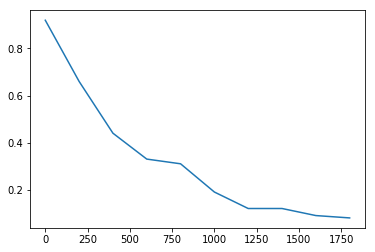

In [9]:
qvm = get_qc('9q-square-qvm', noisy=True)
n_qubits = 1
qubits = list(range(n_qubits))

time_delays = np.arange(0, 2000, 200)
one_probabilities = []

for delay in time_delays:
    p = Program()
    p += X(0)
    p += Pragma("PRESERVE_BLOCK")
    for _ in range(delay):
        p += I(0)

    p += Pragma("END_PRESERVE_BLOCK")
    p = p.measure_all()
    p.wrap_in_numshots_loop(100)

    #Compile and run
    prog = qvm.compile(p)
    result = qvm.run(prog)
    frequencies, _ = get_frequencies(result, n_qubits)
    one_probabilities.append(frequencies[1])
plt.plot(time_delays, one_probabilities)
axes = plt.gca()
axes.set_ylim([0.0,1.0])
plt.show()

As expected, the probability decreases to 0 exponentially.<br>
Let's repeat the same analysis for $T_{2}$. In this case by applying the <i>H</i> gate, than the delay blocks and the <i>H</i> gate again, we should see the probability of measuring $|0\rangle$ decreasing from 1 to $\frac{1}{2}$.

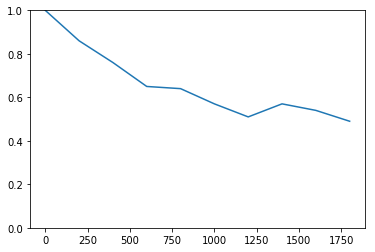

In [13]:
qvm = get_qc('9q-square-qvm', noisy=True)
n_qubits = 1
qubits = list(range(n_qubits))

time_delays = np.arange(0, 2000, 200)
zero_probabilities = []

for delay in time_delays:
    p = Program()
    p += H(0)
    p += Pragma("PRESERVE_BLOCK")
    for _ in range(delay):
        p += I(0)

    p += Pragma("END_PRESERVE_BLOCK")
    p += H(0)
    p = p.measure_all()
    p.wrap_in_numshots_loop(100)

    #Compile and run
    prog = qvm.compile(p)
    result = qvm.run(prog)
    frequencies, _ = get_frequencies(result, n_qubits)
    zero_probabilities.append(1-frequencies[1])
plt.plot(time_delays, zero_probabilities) 
axes = plt.gca()
axes.set_ylim([0.0,1.0])
plt.show()

Again, the experimental result confirms the theoretical behavior.

Rigetti shows the characteristics of its Quantum Computers at https://rigetti.com/qpu.<br>
By looking at the table below each Quantum Computer, even if we cannot replicate the same way in which the qubits are connected to each other (e.g. the double ring for the Rigetti 16Q Aspen-1), we can use the parameter values to model as much as possible the noise for that Quantum Computer using the function <i>add_decoherence_noise(prog, T1, T2, gate_time_1q, gate_time_2q, ro_fidelity)</i>.<br>

For example the Rigetti 8Q Agave, for qubit 0, has 
- $T_{1} = 10.7 \mu s$
- $T_{2} = 10.6 \mu s$
- $\text{gate_time_1q} = 50 ns$
- $\text{gate_time_2q} = 119 ns$ (for the couple 0-1)
- $\text{ro_fidelity} = 0.78$

Let's execute the Grover's algorithm with 2 qubits with the considered architecture.

In [57]:
qvm = get_qc('9q-square-qvm')
n_qubits = 2
qubits = list(range(n_qubits))
p = Program()

def superposition(p, qubits):
    for qubit in qubits:
        p += H(qubit)
        
def oracle(p, qubits):
    p += H(1)
    p += CNOT(0,1)
    p += H(1)
    
def phase_shift(p, qubits):
    for qubit in qubits:
        p += X(qubit)
    p += H(1)
    p += CNOT(0, 1)
    p += H(1)
    for qubit in qubits:
        p += X(qubit)

superposition(p, qubits)
oracle(p, qubits)
superposition(p, qubits)
phase_shift(p, qubits)
superposition(p, qubits)
p = p.measure_all()

#Add noise 
noisy = add_decoherence_noise(p, T1=10.7*10e6, T2=10.6*10e6, 
                              gate_time_1q=50*10e9, gate_time_2q=119*10e9, 
                              ro_fidelity=0.78)

noisy.wrap_in_numshots_loop(100)
grover = qvm.compile(p)
result = qvm.run(grover)

NoisyGateUndefined: Undefined gate and params: CNOT()
Please restrict yourself to I, RX(+/-pi), RX(+/-pi/2), CZ

As we can see from the error, we can use add_decoherence_noise() only to programs having I, RX(+/-pi), RX(+/-pi/2) and CZ gates. This would be achieved by performing qvm.compile(p) before calling the add_decoherence_noise(). But this results in another error because the latter function is not able to get the gates from the compiled program.<br>
We can write the program directly with the mentioned gates. <br>

The optimized version can be easily obtained by compiling the program and printing it.

In [60]:
p_compiled = qvm.compile(p)
print(p_compiled['program'])

DECLARE ro BIT[2]
PRAGMA EXPECTED_REWIRING "#(0 1 2 3 4 5 6 7 8)"
RZ(pi/2) 0
RX(pi/2) 0
RZ(-pi/2) 1
RX(pi/2) 1
CZ 1 0
RX(-pi/2) 0
RZ(pi) 1
RX(pi/2) 1
CZ 1 0
RZ(pi) 0
RX(pi/2) 0
RZ(-pi/2) 0
MEASURE 0 ro[0]
RX(pi/2) 1
RZ(pi/2) 1
MEASURE 1 ro[1]
PRAGMA CURRENT_REWIRING "#(0 1 2 3 4 5 6 7 8)"
HALT



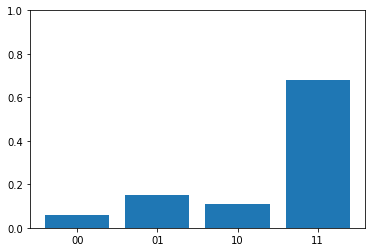

In [56]:
p = Program()
ro = p.declare('ro', memory_type='BIT', memory_size=2)
p += RZ(pi/2, 0)
p += RX(pi/2, 0)
p += RZ(-pi/2, 1)
p += RX(pi/2, 1)
p += CZ(1, 0)
p += RX(-pi/2, 0)
p += RZ(pi, 1)
p += RX(pi/2, 1)
p += CZ(1, 0)
p += RZ(pi, 0)
p += RX(pi/2, 0)
p += RZ(-pi/2, 0)
p += MEASURE(0, ro[0])
p += RX(pi/2, 1)
p += RZ(pi/2, 1)
p += MEASURE(1, ro[1])

noisy = add_decoherence_noise(p, T1=10.7*10e6, T2=10.6*10e6, 
                              gate_time_1q=50*10e9, gate_time_2q=119*10e9, 
                              ro_fidelity=0.78)
noisy.wrap_in_numshots_loop(100)

grover = qvm.compile(noisy)

result = qvm.run(grover)
plot_result(result, n_qubits)

The result is strongly skewed towards $|11\rangle$, which is the correct value. But we can see that the noise has introduced some further uncertainty and we expect to obtain a similar result on the same real quantum computer.